
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f
from copy import deepcopy

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators import MGGPOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


evaluator = Evaluator(function=evaluate_TNK)
evaluator.max_workers = 10

# test check options
vocs = deepcopy(tnk_vocs)
gen = MGGPOGenerator(vocs)
gen.options.model.use_low_noise_prior = True
gen.options.acq.reference_point = {"y1":1.5,"y2":1.5}
X = Xopt(evaluator=evaluator, generator=gen, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0]}))

for i in range(20):
    print(i)
    X.step()

0


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


1
2
3


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


4


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


5


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


6


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


7


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


8


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


9


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


10


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


11


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


12


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


13


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


14


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


15


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


16


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


17


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


18


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


19


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [2]:
X.generator.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000026,False,NaN
2,0.750000,1.000000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000008,False,NaN
3,3.111044,2.742509,3.111044,2.742509,16.146428,11.846398,"[1, 2, 3]",0.000022,False,dummy_constant
4,2.946422,2.853009,2.946422,2.853009,15.724361,11.521628,"[1, 2, 3]",0.000009,False,dummy_constant
5,2.518622,3.127939,2.518622,3.127939,15.142313,10.980898,"[1, 2, 3]",0.000009,False,dummy_constant
...,...,...,...,...,...,...,...,...,...,...
198,1.038990,0.063505,1.038990,0.063505,0.027561,0.481038,"[1, 2, 3]",0.000006,False,dummy_constant
199,1.040334,0.063505,1.040334,0.063505,0.030251,0.482489,"[1, 2, 3]",0.000006,False,dummy_constant
200,0.807767,0.038854,0.807767,0.038854,-0.417862,0.307376,"[1, 2, 3]",0.000006,False,dummy_constant
201,0.834293,0.063505,0.834293,0.063505,-0.334704,0.302280,"[1, 2, 3]",0.000006,False,dummy_constant


## plot results


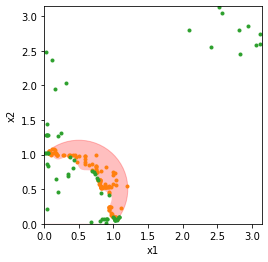

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

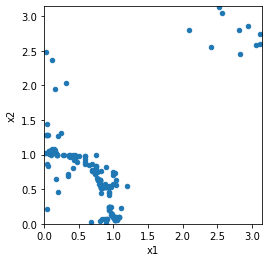

In [5]:
ax = history.plot.scatter("x1", "x2")
ax.set_ylim(0, 3.14)
ax.set_xlim(0, 3.14)
ax.set_aspect("equal")

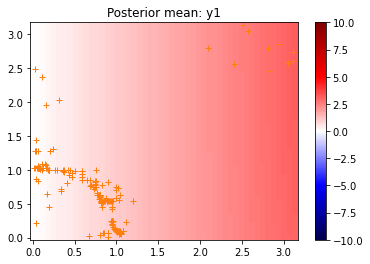

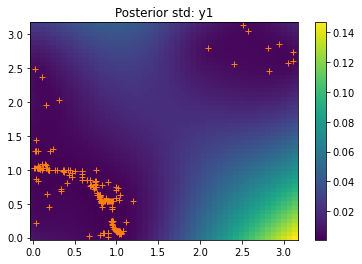

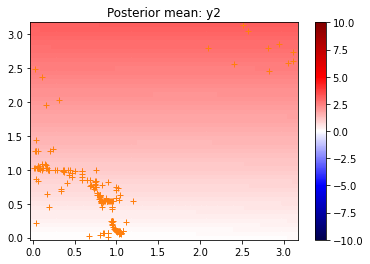

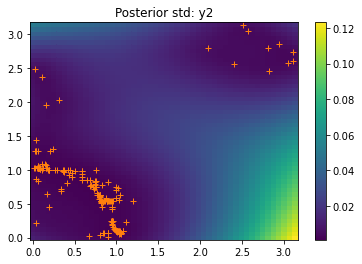

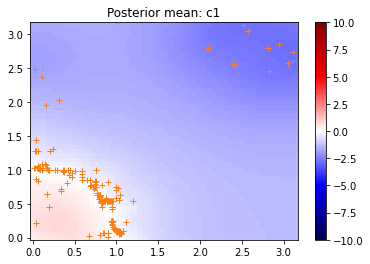

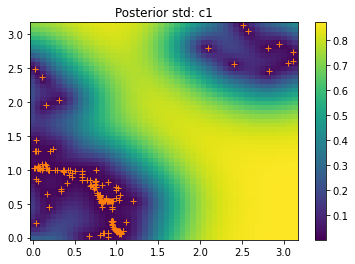

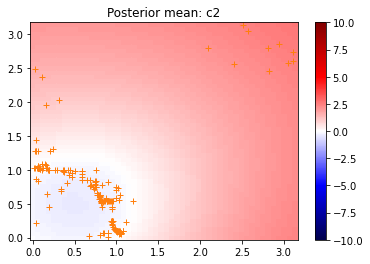

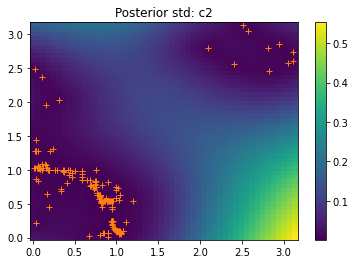

In [8]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(X.generator.data)

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n), cmap="seismic",vmin=-10.0,
                      vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

        fig2, ax2 = plt.subplots()
        ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax2.pcolor(xx, yy, std[:, i].reshape(n, n))
        fig2.colorbar(c)
        ax2.set_title(f"Posterior std: {outputs[i]}")

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[[0.13385644 0.97789311]]


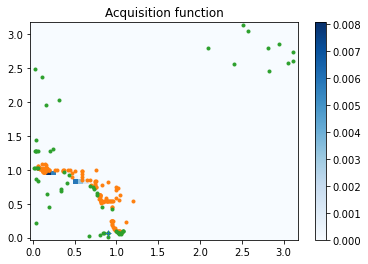

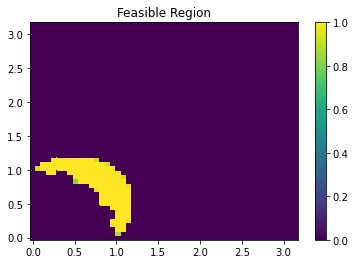

In [7]:
# plot the acquisition function
from xopt.generators.bayesian.utils import feasibility

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = X.generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")